In [0]:
# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('HAR_Dataset',force_remount=True)

rootpath="HAR_Dataset/My Drive"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at HAR_Dataset


In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'HAR_Dataset/My Drive/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'HAR_Dataset/My Drive/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters

epochs = 30

batch_size = 16


n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


# Assignment A) Hypertuning Num of Hidden Units

In [0]:
hidden_Neurons_List=[8,16,32,64,128]

hidden_Neurons_Accuracy=[]

for n_hidden in hidden_Neurons_List:
  model=Sequential()
  
  model.add(LSTM(n_hidden,input_shape=(timesteps,input_dim)))
  
  model.add(Dropout(0.5))
  
  model.add(Dense(n_classes,activation='sigmoid'))
  
  model.summary()
  
  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
  
  model.fit(X_train,
            Y_train,
            batch_size=batch_size,
            validation_data=(X_test, Y_test),
            epochs=epochs)
  
  
  
  score = model.evaluate(X_test, Y_test)
  
  hidden_Neurons_Accuracy.append(score)
  

  
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 8)                 576       
_________________________________________________________________
dropout_11 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 54        
Total params: 630
Trainable params: 630
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.5955 - acc: 0.3632 - val_loss: 1.4712 - val_acc: 0.4547
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.3659 - acc: 0.4550 - val_loss: 1.2986 - val_acc: 0.4625
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.2118 - acc:

TypeError: ignored

In [0]:
print(hidden_Neurons_List)
print("............")
print(hidden_Neurons_Accuracy)




[8, 16, 32, 64, 128]
............
[[0.7497640215505128, 0.6067186969799796], [0.5063654349498706, 0.8486596538853071], [0.44709858201512204, 0.8992195453003053], [0.3953069130833779, 0.9049881235154394], [0.8589523891387445, 0.8920936545841889]]


In [0]:
max_acc=0
y=[]
for i in range(len(hidden_Neurons_List)):
  if hidden_Neurons_Accuracy[i][1]>max_acc:
    max_acc=hidden_Neurons_Accuracy[i][1]
    
    best_n_hidden=hidden_Neurons_List[i]
    
  y.append(hidden_Neurons_Accuracy[i][1])
  print("Number of Hidden Neurons : %d, Accuracy : %f"%(hidden_Neurons_List[i],hidden_Neurons_Accuracy[i][1]))
  

Number of Hidden Neurons : 8, Accuracy : 0.606719
Number of Hidden Neurons : 16, Accuracy : 0.848660
Number of Hidden Neurons : 32, Accuracy : 0.899220
Number of Hidden Neurons : 64, Accuracy : 0.904988
Number of Hidden Neurons : 128, Accuracy : 0.892094


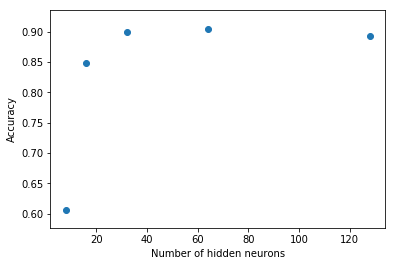

In [0]:
import numpy as np
import matplotlib.pyplot as plt


x = hidden_Neurons_List


plt.scatter(x, y)
plt.xlabel('Number of hidden neurons')
plt.ylabel('Accuracy')
plt.show()

In [0]:

print("The best value of number of hidden neurons is %d"%best_n_hidden)

The best value of number of hidden neurons is 64


# Assignment B) Hypertuning Dropout Rate

In [0]:
dropout_List=[0.1,0.3,0.5,0.7,0.9]

dropout_Accuracy=[]

for dropout in dropout_List:
  model=Sequential()
  
  model.add(LSTM(best_n_hidden,input_shape=(timesteps,input_dim)))
  
  model.add(Dropout(dropout))
  
  model.add(Dense(n_classes,activation='sigmoid'))
  
  model.summary()
  
  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
  
  model.fit(X_train,
            Y_train,
            batch_size=batch_size,
            validation_data=(X_test, Y_test),
            epochs=epochs)
  
  
  
  score = model.evaluate(X_test, Y_test)
  
  dropout_Accuracy.append(score)
  
  
  

W0617 05:37:13.891773 140504591730560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 05:37:13.895210 140504591730560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 05:37:13.906264 140504591730560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 05:37:14.170121 140504591730560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0617 05:37:14.182163 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 37s 5ms/step - loss: 1.2624 - acc: 0.4302 - val_loss: 1.1988 - val_acc: 0.4618
Epoch 2/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.9102 - acc: 0.5945 - val_loss: 0.9746 - val_acc: 0.6060
Epoch 3/30
7352/7352 [==============================] - 36s 5ms/step - loss: 0.6894 

W0617 06:32:15.475296 140504591730560 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 39s 5ms/step - loss: 1.3130 - acc: 0.4402 - val_loss: 1.2271 - val_acc: 0.4048
Epoch 2/30
7352/7352 [==============================] - 37s 5ms/step - loss: 1.0343 - acc: 0.5465 - val_loss: 1.0059 - val_acc: 0.5969
Epoch 3/30
7352/7352 [==============================] - 38s 5ms/step - loss: 0.8394 

W0617 06:51:05.217503 140504591730560 nn_ops.py:4224] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 39s 5ms/step - loss: 1.4367 - acc: 0.3902 - val_loss: 1.2651 - val_acc: 0.4340
Epoch 2/30
7352/7352 [==============================] - 37s 5ms/step - loss: 1.2442 - acc: 0.4649 - val_loss: 1.0755 - val_acc: 0.5199
Epoch 3/30
7352/7352 [==============================] - 37s 5ms/step - loss: 1.1148 

In [0]:
print(dropout_List)
print("............")
print(dropout_Accuracy)

[0.1, 0.3, 0.5, 0.7, 0.9]
............
[[0.26970847920445745, 0.9165252799457075], [0.5416957346667051, 0.8961655921275874], [0.40993680355903883, 0.9083814048184594], [0.560796002992605, 0.8764845605700713], [1.5101637662438, 0.4872751951136749]]


In [0]:
print(dropout_List)
print("............")
print(dropout_Accuracy)



max_acc=0
best_dropout=0
y=[]
for i in range(len(dropout_List)):
  if dropout_Accuracy[i][1]>max_acc:
    max_acc=dropout_Accuracy[i][1]
    best_dropout=dropout_List[i]
  y.append(dropout_Accuracy[i][1])  
  print("Number of Hidden Neurons : %d, Accuracy : %f"%(dropout_List[i],dropout_Accuracy[i][1]))

print("..........\n")
print("The best droput value is : %f"%best_dropout)
  


[0.1, 0.3, 0.5, 0.7, 0.9]
............
[[0.26970847920445745, 0.9165252799457075], [0.5416957346667051, 0.8961655921275874], [0.40993680355903883, 0.9083814048184594], [0.560796002992605, 0.8764845605700713], [1.5101637662438, 0.4872751951136749]]
Number of Hidden Neurons : 0, Accuracy : 0.916525
Number of Hidden Neurons : 0, Accuracy : 0.896166
Number of Hidden Neurons : 0, Accuracy : 0.908381
Number of Hidden Neurons : 0, Accuracy : 0.876485
Number of Hidden Neurons : 0, Accuracy : 0.487275
..........

The best droput value is : 0.100000


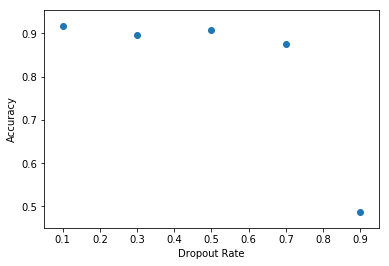

In [0]:
import numpy as np
import matplotlib.pyplot as plt


x = dropout_List


plt.scatter(x, y)
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.show()

# Assignment C) 2 Layer LSTM and Higher dropout

In [0]:
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

from keras.layers import BatchNormalization

In [0]:
epochs = 75
kernel_size = 1 
pool_size = 2

dropout_rate = 0.1

f_act = 'relu'

In [23]:
model = Sequential()
model.add(Conv1D(512, (kernel_size), input_shape=(X_train.shape[1],X_train.shape[2]), activation=f_act, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(pool_size)))
model.add(Dropout(dropout_rate))

model.add(Conv1D(64, (kernel_size), activation=f_act, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(pool_size)))
model.add(Dropout(dropout_rate))


model.add(Conv1D(32, (kernel_size), activation=f_act, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(pool_size)))
model.add(Dropout(dropout_rate))

model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))


model.add(Dense(n_classes,activation='sigmoid'))

#model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X_train,
         Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)


Train on 7352 samples, validate on 2947 samples
Epoch 1/75
7352/7352 [==============================] - 76s 10ms/step - loss: 0.6044 - acc: 0.7349 - val_loss: 0.4009 - val_acc: 0.8412
Epoch 2/75
7352/7352 [==============================] - 72s 10ms/step - loss: 0.2458 - acc: 0.9142 - val_loss: 0.2614 - val_acc: 0.9040
Epoch 3/75
7352/7352 [==============================] - 72s 10ms/step - loss: 0.1767 - acc: 0.9347 - val_loss: 0.2164 - val_acc: 0.9155
Epoch 4/75
7352/7352 [==============================] - 72s 10ms/step - loss: 0.1652 - acc: 0.9395 - val_loss: 0.2499 - val_acc: 0.9189
Epoch 5/75
7352/7352 [==============================] - 72s 10ms/step - loss: 0.1463 - acc: 0.9402 - val_loss: 0.2175 - val_acc: 0.9101
Epoch 6/75
7352/7352 [==============================] - 71s 10ms/step - loss: 0.1405 - acc: 0.9475 - val_loss: 0.1765 - val_acc: 0.9277
Epoch 7/75
7352/7352 [==============================] - 72s 10ms/step - loss: 0.1327 - acc: 0.9470 - val_loss: 0.2068 - val_acc: 0.9281


In [0]:
#model=Sequential()

#model.add(LSTM(200,return_sequences=True,input_shape=(timesteps,input_dim)))

#model.add(LSTM(100))

#model.add(Dropout(0.8))

#model.add(Dense(n_classes,activation='sigmoid'))

#model.summary()

#model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

#model.fit(X_train,
#         Y_train,
#          batch_size=batch_size,
#          validation_data=(X_test, Y_test),
#          epochs=epochs)



#score = model.evaluate(X_test, Y_test)

In [0]:
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [28]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  5      433  ...                   0                 3
STANDING                 0       27  ...                   0                 0
WALKING                  0        0  ...                   3                 0
WALKING_DOWNSTAIRS       0        0  ...                 415                 2
WALKING_UPSTAIRS         0        0  ...                   0               442

[6 rows x 6 columns]


In [26]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [27]:
print(score)

[0.1823121076857176, 0.9637048147261827]


# Conclusions

In [29]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Excercise","Task","Remarks","Accuracy"]


x.add_row(["A","Hypertuning Hidden Neurons","Best value found at 64",0.904988])
x.add_row(["B","Hypertuning Dropout value","Best value found at 0.1",0.916525])
x.add_row(["C","To improve accuracy to beyond 96%","CNN + LSTM used",0.9637048147261827])

print(x)

+-----------+-----------------------------------+-------------------------+--------------------+
| Excercise |                Task               |         Remarks         |      Accuracy      |
+-----------+-----------------------------------+-------------------------+--------------------+
|     A     |     Hypertuning Hidden Neurons    |  Best value found at 64 |      0.904988      |
|     B     |     Hypertuning Dropout value     | Best value found at 0.1 |      0.916525      |
|     C     | To improve accuracy to beyond 96% |     CNN + LSTM used     | 0.9637048147261827 |
+-----------+-----------------------------------+-------------------------+--------------------+
